In [1]:
from firedrake import *
from irksome import RadauIIA, Dt, MeshConstant, TimeStepper, GaussLegendre
import numpy as np

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
butcher_tableau = GaussLegendre(2)
ns = butcher_tableau.num_stages

In [3]:
N = 8
Lx = 3.0
Ly = 1.0
Lz = 1.0
msh = PeriodicBoxMesh(3*N, N, N, Lx, Ly, Lz, directions=(True, False, False), hexahedral=True)
# msh = PeriodicUnitCubeMesh(N, N, N, directions=(True, False, False), hexahedral=True)
V = VectorFunctionSpace(msh, "CG", 2)
W = FunctionSpace(msh, "CG", 1)
Z = V*W

In [4]:
8*8*24

1536

In [5]:
(0.01)/(1/8)


0.08

In [6]:
MC = MeshConstant(msh)
dt = 0.0025# MC.Constant(1.0 / (N))
t = MC.Constant(0.0)
Re = MC.Constant(150.0)

In [7]:
def get_laminar():
    Vh= VectorFunctionSpace(msh, "CG", 2, dim=1)
    
    U = Function(Vh)
    u = TrialFunction(Vh)
    p= TestFunction(Vh)

    bcs = DirichletBC(Vh, as_vector([0.0]), (3, 4, 5, 6))

    C = Constant(as_vector([1.0]))

    F = inner(grad(u), grad(p)) * dx 
    b = inner(C, p) * dx
    solve(F == b, U, bcs=bcs)

    max_velocity = U.dat.data_ro[:].max()
    U.dat.data[:] *= 1 / max_velocity
    
    return U


psi = get_laminar()
U = Function(V)
U.assign(project(as_vector((psi[0], 0, 0)), V))

D = 0.5*(grad(U) + grad(U).T)

In [8]:
out = File("laminar.pvd")
out.write(U)



/Users/danoaballay/venv-firedrake/lib/python3.11/site-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


Eigens

In [9]:
nullvec = Function(Z)
u_null, p_null = nullvec.subfunctions
u_null.assign(as_vector([0.0, 0.0, 0.0]))
p_null.assign(Constant(1.0))


# u, p = split(up)
u, p = TrialFunctions(Z)
v, w = TestFunctions(Z)
L = (-1/Re * inner(grad(u), grad(v)) * dx + inner(p, div(v)) * dx - inner(dot(D, u), v) * dx
     + inner(div(u), w) * dx)
f = inner(u, v) * dx

bcs = [DirichletBC(Z.sub(0), as_vector([0, 0, 0]), (3, 4, 5, 6))]
nsp = MixedVectorSpaceBasis(Z, [Z.sub(0), VectorSpaceBasis(constant=True, comm=msh.comm)])

for bc in bcs:
    bc.apply(nullvec)


NS = VectorSpaceBasis([nullvec])
NS.orthonormalize()


eigenproblem = LinearEigenproblem(A = L, M = f, bcs=bcs, restrict=True)

In [10]:
n_lam = 20
opts = {"eps_gen_hermitian": None,
        "eps_largest_real": None,
        "st_pc_factor_shift_type": "NONZERO"}

eigensolver = LinearEigensolver(eigenproblem, n_evals=n_lam,
                                solver_parameters=opts)

nconv = eigensolver.solve()

In [11]:
lams = []
for i in range(n_lam):
    lam = eigensolver.eigenvalue(i)
    lams.append(lam)    
    print(f"Eigenvalue {i}: {lam}")

Eigenvalue 0: 0.002984594032771431
Eigenvalue 1: 0.00298459403330468
Eigenvalue 2: 0.002984594035776594
Eigenvalue 3: 0.002984594036042213
Eigenvalue 4: -0.019774057183168162
Eigenvalue 5: -0.019774057183680256
Eigenvalue 6: -0.02666404803761897
Eigenvalue 7: -0.026664048038087584
Eigenvalue 8: -0.0266640480399674
Eigenvalue 9: -0.026664048041168776
Eigenvalue 10: -0.05767182152168749
Eigenvalue 11: -0.08544272115959585
Eigenvalue 12: -0.08544272116306592
Eigenvalue 13: -0.12418424079106608
Eigenvalue 14: -0.12418424079486517
Eigenvalue 15: -0.12801322144279534
Eigenvalue 16: -0.13114924622930843
Eigenvalue 17: -0.1567901768055058
Eigenvalue 18: -0.1567901768081749
Eigenvalue 19: -0.15679017681037338


In [12]:
idx_lam = np.argmax(np.real(lams))
lam = eigensolver.eigenvalue(idx_lam)
eigen_real, eigen_imag = eigensolver.eigenfunction(idx_lam)
u0, p0 = eigen_real.subfunctions

print(f"Most unstable eigenvalue: {lam}")

Most unstable eigenvalue: 0.002984594036042213


In [ ]:
up = Function(Z)
u_, p_ = up.subfunctions
u_.rename('Velocity')
p_.rename("Pressure")


u_.dat.data[:] = np.real(u0.dat.data_ro[:])
p_.dat.data[:] = np.real(p0.dat.data_ro[:])

u_norm = sqrt(assemble(inner(u_, u_) * dx))
u_.dat.data[:] *= 1 / u_norm


out = File("output.pvd")
out.write(u_, p_)


u, p = split(up)
v, w = TestFunctions(Z)
F = (inner(Dt(u), v) * dx + inner(dot(grad(u), u), v) * dx
     + inner(dot(grad(U), u), v) * dx + inner(dot(grad(u), U), v) * dx
     + 1/Re * inner(grad(u), grad(v)) * dx - inner(p, div(v)) * dx
     + inner(div(u), w) * dx)

bcs = [DirichletBC(Z.sub(0), as_vector([0, 0, 0]), (3, 4, 5, 6))]

/Users/danoaballay/venv-firedrake/lib/python3.11/site-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


In [14]:
luparams = {"mat_type": "aij",
            "snes_type": "newtonls",
            "snes_monitor": None,
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
            "snes_linesearch_type": "l2",
            "snes_force_iteration": 1,
            "snes_rtol": 1e-8,
            "snes_atol": 1e-8,
            }

In [15]:
nsp = MixedVectorSpaceBasis(Z, [Z.sub(0), VectorSpaceBasis(constant=True, comm=msh.comm)])

In [16]:
stepper = TimeStepper(F, butcher_tableau, t, dt, up, bcs=bcs,
                      solver_parameters=luparams, nullspace=nsp)

In [36]:
# energy = []
# times = []

# out = File(f"ns_unsteady_{lam}.pvd")
# out.write(u_, p_, time=float(t))

# E = 0.5 * inner(real(u_), real(u_)) * dx
# times.append(float(t))
# energy.append(assemble(E))
# print(f"  Energy: {energy[-1]}")

N = int(1.6/dt)

for _ in range(N):
    max_u = np.max(np.abs(u_.dat.data_ro[:, 0]))
    max_v = np.max(np.abs(u_.dat.data_ro[:, 1]))
    max_w = np.max(np.abs(u_.dat.data_ro[:, 2]))


    CFL_max = max(max_u, max_v, max_w) * dt / (Lx / (3*N))
    print(f"CFL max: {CFL_max}")

    print(f"Stepping from time {float(t)}")
    stepper.advance()
    t.assign(float(t) + float(dt))
    et = assemble(E)
    times.append(float(t))
    energy.append(et)
    print(f"  Energy: {et}")

    out.write(u_, p_, time=float(t))

CFL max: 0.1030337301716973
Stepping from time 4.41499999999999
  0 SNES Function norm 4.118352442109e-06


/Users/danoaballay/venv-firedrake/lib/python3.11/site-packages/firedrake/function.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self.dat.data_ro[0])


  1 SNES Function norm 4.790352325047e-12
  Energy: (0.0008182527369720748+0j)
CFL max: 0.1029630287028488
Stepping from time 4.417499999999991
  0 SNES Function norm 4.114830090840e-06
  1 SNES Function norm 4.873235568083e-12
  Energy: (0.0008169968829830378+0j)
CFL max: 0.10289146189893024
Stepping from time 4.419999999999991
  0 SNES Function norm 4.111310862524e-06
  1 SNES Function norm 4.844736930106e-12
  Energy: (0.0008157428314962652+0j)
CFL max: 0.10281903169825202
Stepping from time 4.422499999999991
  0 SNES Function norm 4.107794875081e-06
  1 SNES Function norm 4.834813895205e-12
  Energy: (0.0008144905803755763+0j)
CFL max: 0.10274574004956072
Stepping from time 4.424999999999992
  0 SNES Function norm 4.104282000805e-06
  1 SNES Function norm 4.834542681132e-12
  Energy: (0.0008132401274858381+0j)
CFL max: 0.1026715889135713
Stepping from time 4.427499999999992
  0 SNES Function norm 4.100772331730e-06
  1 SNES Function norm 4.809376121918e-12
  Energy: (0.000811991470

/Users/danoaballay/venv-firedrake/lib/python3.11/site-packages/firedrake/function.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self.dat.data_ro[0])


  0 SNES Function norm 2.527029245544e-06
  1 SNES Function norm 8.913404139833e-12
  Energy: (0.00033041294895744987+0j)
CFL max: 0.06624692661891182
Stepping from time 5.865000000000217
  0 SNES Function norm 2.524925805572e-06
  1 SNES Function norm 8.945671685061e-12
  Energy: (0.0003298897820314937+0j)
CFL max: 0.06619640253637259
Stepping from time 5.867500000000217
  0 SNES Function norm 2.522824293671e-06
  1 SNES Function norm 8.931240339094e-12
  Energy: (0.000329367434000219+0j)
CFL max: 0.06614540684127798
Stepping from time 5.870000000000218
  0 SNES Function norm 2.520724512370e-06
  1 SNES Function norm 9.018634756277e-12
  Energy: (0.0003288459036474856+0j)
CFL max: 0.06609394063177113
Stepping from time 5.872500000000218
  0 SNES Function norm 2.518626717859e-06
  1 SNES Function norm 9.004919551499e-12
  Energy: (0.00032832518975845176+0j)
CFL max: 0.06604200500184147
Stepping from time 5.8750000000002185
  0 SNES Function norm 2.516530533190e-06
  1 SNES Function nor

In [30]:
len(energy)

967

In [28]:
len(times)

967

Initial energy growth rate: (0.0029817807161575116+0j)


/Users/danoaballay/venv-firedrake/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/danoaballay/venv-firedrake/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/n_/86gc5_ss68qf_7rmsgy_3hvw0000gn/T/ipykernel_22569/3200062197.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


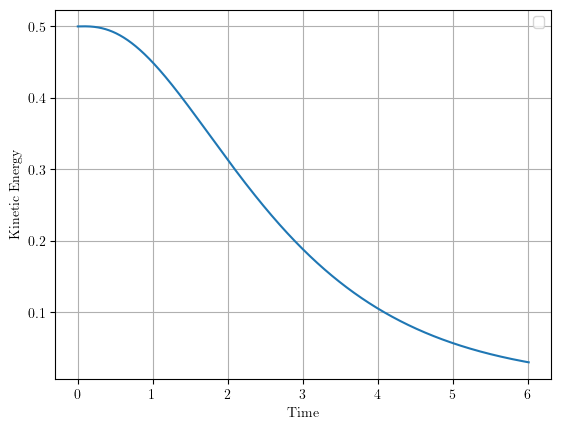

In [44]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

dx0 = (energy[1] - energy[0])*100 / (times[1] - times[0])
print(f"Initial energy growth rate: {dx0}")
x = np.linspace(0, 0.2, 100)
y = dx0 * x + energy[0]*100

plt.figure()
plt.plot(times, np.array(energy)*100)
# plt.plot(x, y, 'r--', label="Initial growth rate")
plt.xlabel("Time")
plt.ylabel("Kinetic Energy")
# plt.title("Kinetic Energy vs Time")
plt.grid(True)
plt.legend()
plt.savefig('energyplot.pdf')
plt.show()


Initial energy growth rate: (0.0029817807161575116+0j)


/Users/danoaballay/venv-firedrake/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/danoaballay/venv-firedrake/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/n_/86gc5_ss68qf_7rmsgy_3hvw0000gn/T/ipykernel_22569/3290896585.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


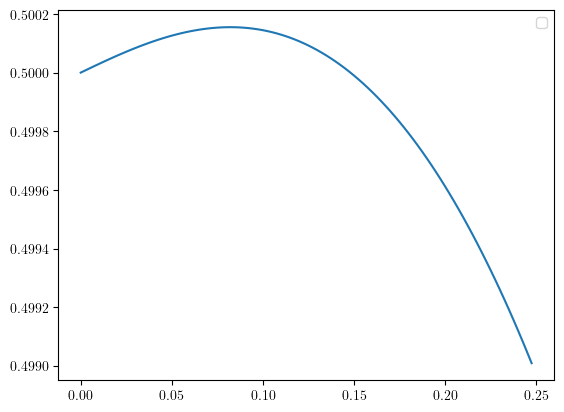

In [45]:
dx0 = (energy[1] - energy[0])*100 / (times[1] - times[0])
print(f"Initial energy growth rate: {dx0}")
x = np.linspace(0, 0.2, 100)
y = dx0 * x + energy[0]*100

plt.figure()
plt.plot(times[0:100], np.array(energy[0:100])*100)
# plt.plot(x, y, 'r--', label="Initial growth rate")
# plt.xlabel("Time")
# plt.ylabel("Kinetic Energy")
# plt.title("Kinetic Energy vs Time")
# plt.grid(True)
plt.legend()
plt.savefig('energyzoomin.pdf')
plt.show()